# Credit Card Approval Prediction

The project aims to build a machine learning model to predict if an applicant is 'good' or 'bad' client. The data is from Kaggle (by Seanny) and the structure of the solution is also based on Seanny's solution. 

The main objective is to learn how the solution structure, ML model comparison, and most importantly, improve on any possible loopholes. 

In [332]:
# Import libraries
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

## 1.1 Data acquisition

There are multiple ways to acquire data. It could be by web scraping, fetching from APIs or SQL queries from existing databases, data acquisition is a fundamental part of getting to import to the working environment. 

In [333]:
data = pd.read_csv("input/application_record.csv", encoding='utf-8')
record = pd.read_csv("input/credit_record.csv", encoding='utf-8')

In [334]:
#To form a white background display for graphs to come.
plt.rcParams['figure.facecolor']='white'

## 1.2a Scoping the dataframe

This part aims to have a first look at the data we have. As we have imported above, we have 2 sets of data:  
1. Application record - demographic factors associated with each borrowers.
2. Credit record - borrowers' payment behaviour

In [335]:
data.head(5) 

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Some description of the data:

1. **DAYS_EMPLOYED**: Start date of employment. Counted backwards from current day (0). If positive, it means the person currently unemployed. 

In [336]:
record.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Some description of the data:
1. **MONTHS_BALANCE**: The month of the extracted data is the starting point, backwards, 0 is current month, -1 is previous month and so on. 
2. **STATUS**: values corresponds to:    
        0: 1-29 dpd  
        1: 30-59 dpd  
        2: 60-69 dpd  
        3: 90-119 dpd  
        4: 120-149 dpd  
        5: Overdue or bad debts/ write-off for more than 150 days  
        C: paid off that month  
        X: no loan for the month  

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [338]:
data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [339]:
# check missing values
data.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

## 1.2b Data Preparation

In this example, we set the default definition to be > 60 days past due (dpd).

Actions implemented under this section:  
* merge record along the ID column. We would like the output variable ("Credit record score") to be within the same dataframe as the input.   
* we are going to make a new column (dataframe object) called 'dep_value' which indicates/ denotes credit users with more than 2 months (60 dpd) to be as "Yes".  
* Then, we are going to add this new column to our master dataframe. 

In [340]:
begin_month = pd.DataFrame(record.groupby(["ID"])["MONTHS_BALANCE"].agg(min))   # find  users' account open month i.e. smallest negative number by defn of MONTH_BALANCE column
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'begin_month'})
new_data = pd.merge(data, begin_month, how='left', on="ID")                     # merge to application data

In [341]:
new_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [342]:
record['dep_value'] = None
record['dep_value'][record['STATUS'] == '2']='Yes'
record['dep_value'][record['STATUS'] == '3']='Yes'
record['dep_value'][record['STATUS'] == '4']='Yes'
record['dep_value'][record['STATUS'] == '5']='Yes'

Our 'dep_value' of the record data frame only contains None and Yes. We'll use this information to identify IDs which have experienced default.

In [343]:
cpunt=record.groupby('ID').count()               # count non-null entries
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes' # have experienced default
cpunt['dep_value'][cpunt['dep_value'] == 0]='No' # never default
cpunt = cpunt[['dep_value']]                     # take a column but still in DataFrame format

# add in the default tagging
new_data=pd.merge(new_data, cpunt, how='inner', on='ID')
new_data['target']=new_data['dep_value']
new_data.loc[new_data['target']=='Yes', 'target']=1
new_data.loc[new_data['target']=='No', 'target']=0


In [344]:
print(cpunt['dep_value'].value_counts())
new_data['target'].value_counts()

dep_value
No     45318
Yes      667
Name: count, dtype: int64


target
0    35841
1      616
Name: count, dtype: int64

As seen from the above, there is a huge imbalance in the target feature class distribution. This will be addressed at a later stage

In [345]:
mismatch_ls = pd.DataFrame(cpunt.index)
# Convert the 'ID' columns from both DataFrames to sets
set_new_data = set(new_data['ID'])
set_mismatch_ls = set(mismatch_ls['ID'])

# Find the missing IDs
missing_ids = set_mismatch_ls - set_new_data\

# Convert the result back to a list
missing_ids_list = list(missing_ids)

#print(45318 - 35841 + 667 - 616)
print(missing_ids_list)
len(missing_ids_list)

[5016224, 5016225, 5016226, 5016227, 5016228, 5016229, 5016230, 5016231, 5016232, 5016233, 5016234, 5016235, 5016236, 5016237, 5016238, 5016239, 5016241, 5016242, 5016243, 5016244, 5016245, 5016246, 5016247, 5016248, 5016249, 5016250, 5016251, 5016252, 5016253, 5016255, 5016256, 5016258, 5016259, 5016260, 5016261, 5016262, 5016263, 5016264, 5016265, 5016266, 5016268, 5016270, 5016274, 5016275, 5016276, 5016278, 5016279, 5016280, 5016281, 5016282, 5016283, 5016284, 5016285, 5016286, 5016287, 5016288, 5016289, 5016291, 5016292, 5016293, 5016294, 5016295, 5016296, 5016297, 5016298, 5016299, 5016300, 5016301, 5016303, 5016304, 5016305, 5016306, 5016307, 5016308, 5016310, 5016311, 5016313, 5016314, 5016315, 5016316, 5016318, 5016320, 5016324, 5016325, 5016326, 5016327, 5016329, 5016330, 5016331, 5016332, 5016336, 5016337, 5016338, 5016340, 5016341, 5016342, 5016343, 5016344, 5016345, 5016346, 5016347, 5016348, 5016349, 5016350, 5016351, 5016352, 5016353, 5016354, 5016357, 5016358, 5016359, 

9528

From the above, we can see that there are 9528 mismatch IDs between the record data and also the application data. However, these mismatch does not result in missing record for all the IDs available in the application data. 

This gives us a workable dataframe. The target feature would be if the customer hasn't been approved for a credit card: 0 or has been approved for a credit card: 1.

***

## 1.3 Data Cleaning

In [346]:
# rename features
new_data.rename(columns={'CODE_GENDER': 'Gender', 'FLAG_OWN_CAR': 'Car', 'FLAG_OWN_REALTY': 'Reality', 
                         'CNT_CHILDREN': 'Child_No', 'AMT_INCOME_TOTAL': 'income_tot', 
                         'NAME_EDUCATION_TYPE': 'edu_type', 'NAME_FAMILY_STATUS':'fam_type',
                         'NAME_HOUSING_TYPE':'house_type', 'FLAG_EMAIL': 'email',
                         'NAME_INCOME_TYPE': 'income_type', 'FLAG_WORK_PHONE': 'work_phone',
                         'FLAG_PHONE': 'phone', 'CNT_FAM_MEMBERS': 'fam_size',
                         'OCCUPATION_TYPE': 'occup_type'
                         }, inplace=True)

In [347]:
# drop rows with missing values
new_data.dropna()
new_data=new_data.mask(new_data=='NULL').dropna()

In [348]:
new_data.isna().sum()

ID               0
Gender           0
Car              0
Reality          0
Child_No         0
income_tot       0
income_type      0
edu_type         0
fam_type         0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occup_type       0
fam_size         0
begin_month      0
dep_value        0
target           0
dtype: int64

In [349]:
# remove duplicates
new_data=new_data.drop_duplicates(subset=new_data.columns[1:], keep='first')

### Information Value and Weight of Evidence

Create dataframe object to rank variables based on their **Information Value**.

In [350]:
ivtable=pd.DataFrame(new_data.columns, columns=['variable']) # create dataframe with new_data column names as the values in column 'variable'
ivtable['IV']=None
namelist= ['FLAG_MOBIL', 'begin_month', 'dep_value', 'target', 'ID']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable']==i].index, inplace=True)


<details>
  <summary><b>For the interested....</b></summary>
    Weight of Evidence(WoE):
        $$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
        $wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).
    <section>
    Information Value (IV):
        $$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
        The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
        $$IV = \sum\limits_i^n {I{V_i}} $$
    </section>
   
</details>

Relationship between IV value and predictive power

| IV| Ability to predict | 
|:------|:------:| 
| <0.02 | Almost no predictive power | 
|0.02~0.1 |weak predictive power|
|0.1~0.3|Moderate predictive power|
|0.3~0.5|Strong predictive power|
|>0.5|Predictive power is too strong, need to check variables| 

In [351]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    lst=[]
    df[feature]=df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val=list(df[feature].unique())[i]
        lst.append([feature,                                                      # Variable
                    val,                                                          # Value
                    df[df[feature]==val].count()[feature],                        # All
                    df[(df[feature]==val) & (df[target]==0)].count()[feature],    # Good
                    df[(df[feature]==val) & (df[target]==1)].count()[feature]])   # Bad
        
    data=pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV']=data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv=data['IV'].sum()
    print('This variable\'s IV is:', iv)
    print(df[feature].value_counts())
    return iv, data
        
        

In [352]:
def convert_dummy(df, feature, rank=0):
    pos=pd.get_dummies(df[feature], prefix=feature)
    mode=df[feature].value_counts().index[rank]
    biggest= feature + '_' + str(mode)
    pos.drop([biggest], axis=1, inplace=True)
    df.drop([feature], axis=1, inplace=True)
    df=df.join(pos)
    return df

In [353]:
# binning
def get_category(df, col, binsnum, labels, qcut=False):
    if qcut:
        localdf= pd.qcut(df[col], q=binsnum, labels=labels) # quantile cut
    else:
        localdf= pd.cut(df[col], bins=binsnum, labels= labels) # equal-length cut

    localdf= pd.DataFrame(localdf)
    name= 'gp'+'_'+col
    localdf[name]= localdf[col]
    df= df.join(localdf[name])
    df[name]=df[name].astype(object)
    
    return df

In [354]:
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt= '.2f' if normalize else 'd'
    thresh=cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment= 'center',
                 color='white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Gender

In [355]:
new_data['Gender']= new_data['Gender'].replace(['F', 'M'], [0,1])
iv, data= calc_iv(new_data, 'Gender', 'target')
ivtable.loc[ivtable['variable']=='Gender', 'IV']=iv
data.head()

This variable's IV is: 0.021858217664351712
Gender
0    13772
1     8425
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Gender,0,13772,13548,224,0.620444,0.016265,0.621782,0.54902,0.124455,0.009056
1,Gender,1,8425,8241,184,0.379556,0.021840,0.378218,0.45098,-0.175952,0.012803


#### Having a car or not

In [356]:
new_data['Car'] = new_data['Car'].replace(['N','Y'],[0,1])
iv, data=calc_iv(new_data,'Car','target')
ivtable.loc[ivtable['variable']=='Car','IV']=iv
data.head()

This variable's IV is: 0.000158276043654339
Car
0    12922
1     9275
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Car,0,12922,12682,240,0.582151,0.018573,0.582037,0.588235,-0.010593,0.000066
1,Car,1,9275,9107,168,0.417849,0.018113,0.417963,0.411765,0.014941,0.000093


#### Having house reality or not

In [357]:
new_data['Reality'] = new_data['Reality'].replace(['N','Y'],[0,1])
iv, data=calc_iv(new_data,'Reality','target')
ivtable.loc[ivtable['variable']=='Reality','IV']=iv
data.head()

This variable's IV is: 0.029211910779123988
Reality
1    14540
0     7657
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Reality,0,7657,7483,174,0.344957,0.022724,0.34343,0.426471,-0.21656,0.017983
1,Reality,1,14540,14306,234,0.655043,0.016094,0.65657,0.573529,0.13522,0.011229


#### Having a phone or not

In [358]:
new_data['phone']=new_data['phone'].astype(str)
# new_data.drop(new_data[new_data['phone'] == 'nan' ].index, inplace=True)
iv, data=calc_iv(new_data,'phone','target')
ivtable.loc[ivtable['variable']=='phone','IV']=iv
data.head()

This variable's IV is: 0.0006815444035068829
phone
0    15711
1     6486
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,phone,0,15711,15427,284,0.707798,0.018077,0.708018,0.696078,0.017007,0.000203
1,phone,1,6486,6362,124,0.292202,0.019118,0.291982,0.303922,-0.040077,0.000478


#### Having an email or not

In [359]:
new_data['email']=new_data['email'].astype(str)
iv, data=calc_iv(new_data,'email','target')
ivtable.loc[ivtable['variable']=='email','IV']=iv
data.head()

This variable's IV is: 4.4517835868401364e-05
email
0    19956
1     2241
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,email,0,19956,19590,366,0.89904,0.018340,0.899078,0.897059,0.002248,0.000005
1,email,1,2241,2199,42,0.10096,0.018742,0.100922,0.102941,-0.019805,0.000040


#### Having a Work Phone or not

In [360]:
# new_data['work_phone']=new_data['work_phone'].astype(str)
iv, data = calc_iv(new_data,'work_phone','target')
# new_data.drop(new_data[new_data['work_phone'] == 'nan' ].index, inplace=True)
ivtable.loc[ivtable['variable']=='work_phone','IV']=iv
data.head()

This variable's IV is: 0.002563092040317118
work_phone
0    16112
1     6085
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,work_phone,0,16112,15825,287,0.725864,0.017813,0.726284,0.703431,0.031971,0.000731
1,work_phone,1,6085,5964,121,0.274136,0.019885,0.273716,0.296569,-0.080187,0.001832


## Numerical values categorisation (Binning)

The below features are numerical columns categorised to different bins. This is so that we can perform IV and WoE calculation for them. 

#### Children Numbers
For this variable, we'll only group to three possible values; 0, 1, 2+

In [361]:
print(new_data['Child_No'].value_counts())
new_data.loc[new_data['Child_No'] >= 2,'Child_No']='2More'
print(new_data['Child_No'].value_counts(sort=False))

Child_No
0     14035
1      5403
2      2405
3       284
4        48
5        16
14        3
7         2
19        1
Name: count, dtype: int64
Child_No
0        14035
2More     2759
1         5403
Name: count, dtype: int64


In [362]:
iv, data=calc_iv(new_data,'Child_No','target')
ivtable.loc[ivtable['variable']=='Child_No','IV']=iv
data.head()

This variable's IV is: 0.0009901041622527066
Child_No
0        14035
1         5403
2More     2759
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,Child_No,0,14035,13771,264,0.632293,0.018810,0.632016,0.647059,-0.023522,0.000354
1,Child_No,1,5403,5308,95,0.243411,0.017583,0.243609,0.232843,0.045200,0.000487
2,Child_No,2More,2759,2710,49,0.124296,0.017760,0.124375,0.120098,0.034990,0.000150


In [363]:
new_data = convert_dummy(new_data,'Child_No')

Now we have created additional columns which correspond to each values of 'Child_No'; 'Child_No_1', 'Child_No_2More', with Child = 0 as the default.

#### Annual Income

(2.544, 18.18]      13048
(18.18, 33.66]       7395
(33.66, 49.14]       1427
(49.14, 64.62]        158
(64.62, 80.1]         107
(80.1, 95.58]          46
(95.58, 111.06]         4
(111.06, 126.54]        3
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: count, dtype: int64


<Axes: ylabel='Frequency'>

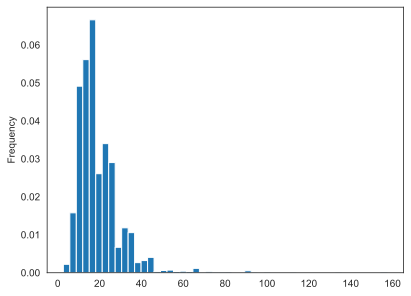

In [364]:
# new_data['income_tot']=new_data['income_tot'].astype(object) # convert column's data type to a generic object data type
new_data['income_tot'] = new_data['income_tot']/10000 
print(new_data['income_tot'].value_counts(bins=10,sort=False))
new_data['income_tot'].plot(kind='hist',bins=50,density=True)

In [365]:
new_data['income_tot'] = new_data['income_tot'].astype('float64')
# Note: def get_category(df, col, binsnum, labels, qcut=False):
new_data= get_category(new_data, 'income_tot', 3, ["low", "medium", "high"], qcut=True)
# Note: def calc_iv(df, feature, target, pr=False):
iv, data= calc_iv(new_data, 'gp_income_tot', 'target')
# .loc[] function is used to locate rows in the DataFrame where the condition is True
ivtable.loc[ivtable['variable']=='income_tot', 'IV']= iv
data.head()

This variable's IV is: 0.004630664623362465
gp_income_tot
low       7999
high      7357
medium    6841
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_income_tot,high,7357,7209,148,0.331441,0.020117,0.330855,0.362745,-0.092020,0.002935
1,gp_income_tot,low,7999,7857,142,0.360364,0.017752,0.360595,0.348039,0.035440,0.000445
2,gp_income_tot,medium,6841,6723,118,0.308195,0.017249,0.308550,0.289216,0.064712,0.001251


In [366]:
new_data = convert_dummy(new_data,'gp_income_tot')

#### Age

(19.951999999999998, 24.7]    0.026580
(24.7, 29.4]                  0.134883
(29.4, 34.1]                  0.168897
(34.1, 38.8]                  0.141235
(38.8, 43.5]                  0.171014
(43.5, 48.2]                  0.142362
(48.2, 52.9]                  0.098347
(52.9, 57.6]                  0.076587
(57.6, 62.3]                  0.033022
(62.3, 67.0]                  0.007073
Name: proportion, dtype: float64


<Axes: ylabel='Frequency'>

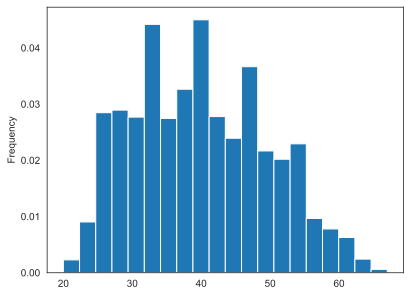

In [367]:
new_data['Age']=-(new_data['DAYS_BIRTH'])//365	
print(new_data['Age'].value_counts(bins=10,normalize=True,sort=False))
new_data['Age'].plot(kind='hist',bins=20,density=True)

In [368]:
new_data = get_category(new_data,'Age',5, ["lowest","low","medium","high","highest"])
iv, data = calc_iv(new_data,'gp_Age','target')
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','IV'] = iv
data.head()

This variable's IV is: 0.06471575027732059
gp_Age
medium     6956
low        6884
high       3883
lowest     3584
highest     890
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_Age,high,3883,3794,89,0.174934,0.022920,0.174125,0.218137,-0.225354,0.009918
1,gp_Age,highest,890,886,4,0.040096,0.004494,0.040663,0.009804,1.422529,0.043898
2,gp_Age,low,6884,6767,117,0.310132,0.016996,0.310570,0.286765,0.079746,0.001898
3,gp_Age,lowest,3584,3504,80,0.161463,0.022321,0.160815,0.196078,-0.198260,0.006991
4,gp_Age,medium,6956,6838,118,0.313376,0.016964,0.313828,0.289216,0.081673,0.002010


In [369]:
new_data = convert_dummy(new_data,'gp_Age')

#### Working Years
+ Equal-length Bucketing

<Axes: ylabel='Frequency'>

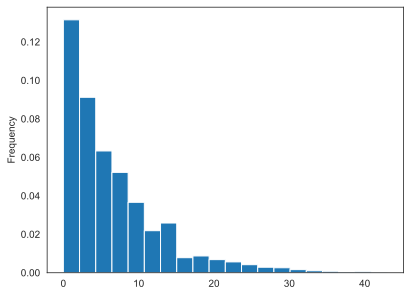

In [370]:
# Note: new_data['DAYS_EMPLOYED'] - Values counted backwards from current day(0). If positive, it means the person currently unemployed.
new_data['work_time']=-(new_data['DAYS_EMPLOYED'])//365	
new_data[new_data['work_time']<0] = np.nan                              # replace unemployed (days employed > 0) by na
new_data['work_time'].fillna(new_data['work_time'].mean(),inplace=True) # replace na by mean
new_data['work_time'].plot(kind='hist',bins=20,density=True)

In [371]:
new_data = get_category(new_data,'work_time',5, ["lowest","low","medium","high","highest"])
# Note: get_category creates additional column 'gp_' + 'variable_to_bin'
iv, data=calc_iv(new_data,'gp_work_time','target')
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','IV']=iv
data.head()

This variable's IV is: 0.03806348730400741
gp_work_time
lowest     16136
low         4393
medium      1206
high         383
highest       79
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_work_time,high,383,381,2,0.017255,0.005222,0.017486,0.004902,1.271759,0.016004
1,gp_work_time,highest,79,79,0,0.003559,0.000000,0.003626,0.000000,0.000000,0.000000
2,gp_work_time,low,4393,4329,64,0.197910,0.014569,0.198678,0.156863,0.236315,0.009882
3,gp_work_time,lowest,16136,15810,326,0.726945,0.020203,0.725595,0.799020,-0.096393,0.007078
4,gp_work_time,medium,1206,1190,16,0.054332,0.013267,0.054615,0.039216,0.331227,0.005101


In [372]:
new_data = convert_dummy(new_data,'gp_work_time')

#### Famliy Size

In [373]:
new_data['fam_size'].value_counts(sort=True)

fam_size
2.0     11191
3.0      4614
1.0      3768
4.0      2281
5.0       278
6.0        43
7.0        16
15.0        3
9.0         2
20.0        1
Name: count, dtype: int64

In [374]:
new_data['fam_size']=new_data['fam_size'].astype(int)
new_data['fam_size_gp']=new_data['fam_size']
new_data['fam_size_gp']=new_data['fam_size_gp'].astype(object)
new_data.loc[new_data['fam_size_gp']>=3,'fam_size_gp']='3more'

iv, data=calc_iv(new_data,'fam_size_gp','target')
ivtable.loc[ivtable['variable']=='fam_size','IV']=iv
data.head()

This variable's IV is: 0.0070323809856006215
fam_size_gp
2        11191
3more     7238
1         3768
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,fam_size_gp,1,3768,3686,82,0.169753,0.021762,0.169168,0.200980,-0.172315,0.005482
1,fam_size_gp,2,11191,10990,201,0.504167,0.017961,0.504383,0.492647,0.023543,0.000276
2,fam_size_gp,3more,7238,7113,125,0.326080,0.017270,0.326449,0.306373,0.063472,0.001274


In [375]:
new_data = convert_dummy(new_data,'fam_size_gp')

### Categorical Features

#### Income Type

In [376]:
# print(new_data['income_type'].value_counts(sort=False))
# print(new_data['income_type'].value_counts(normalize=True,sort=False))

new_data.loc[new_data['income_type']=='Pensioner','income_type']='State servant'
new_data.loc[new_data['income_type']=='Student','income_type']='State servant'

iv, data=calc_iv(new_data,'income_type','target')
ivtable.loc[ivtable['variable']=='income_type','IV']=iv
data.head()

This variable's IV is: 0.00027673320053701466
income_type
Working                 13785
Commercial associate     6228
State servant            2184
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,income_type,Commercial associate,6228,6113,115,0.280578,0.018465,0.280554,0.281863,-0.004653,0.000006
1,income_type,State servant,2184,2142,42,0.098392,0.019231,0.098306,0.102941,-0.046068,0.000214
2,income_type,Working,13785,13534,251,0.621030,0.018208,0.621139,0.615196,0.009614,0.000057


In [377]:
new_data = convert_dummy(new_data,'income_type')

#### Occupation Type

In [378]:
new_data.loc[(new_data['occup_type']=='Cleaning staff') | (new_data['occup_type']=='Cooking staff') | (new_data['occup_type']=='Drivers') | (new_data['occup_type']=='Laborers') | (new_data['occup_type']=='Low-skill Laborers') | (new_data['occup_type']=='Security staff') | (new_data['occup_type']=='Waiters/barmen staff'),'occup_type']='Laborwk'
new_data.loc[(new_data['occup_type']=='Accountants') | (new_data['occup_type']=='Core staff') | (new_data['occup_type']=='HR staff') | (new_data['occup_type']=='Medicine staff') | (new_data['occup_type']=='Private service staff') | (new_data['occup_type']=='Realty agents') | (new_data['occup_type']=='Sales staff') | (new_data['occup_type']=='Secretaries'),'occup_type']='officewk'
new_data.loc[(new_data['occup_type']=='Managers') | (new_data['occup_type']=='High skill tech staff') | (new_data['occup_type']=='IT staff'),'occup_type']='hightecwk'
# print(new_data['occup_type'].value_counts())

iv, data=calc_iv(new_data,'occup_type','target')
ivtable.loc[ivtable['variable']=='occup_type','IV']=iv
data.head()         

This variable's IV is: 0.0038482824390668217
occup_type
Laborwk      9307
officewk     8977
hightecwk    3913
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,occup_type,Laborwk,9307,9132,175,0.419291,0.018803,0.419111,0.428922,-0.023139,0.000227
1,occup_type,hightecwk,3913,3834,79,0.176285,0.020189,0.175960,0.193627,-0.095677,0.001690
2,occup_type,officewk,8977,8823,154,0.404424,0.017155,0.404929,0.377451,0.070271,0.001931


In [379]:
new_data = convert_dummy(new_data,'occup_type')

#### House Type

In [380]:
iv, data=calc_iv(new_data,'house_type','target')
ivtable.loc[ivtable['variable']=='house_type','IV']=iv
data.head()

This variable's IV is: 0.008714195864871505
house_type
House / apartment      19520
With parents            1278
Municipal apartment      726
Rented apartment         374
Office apartment         175
Co-op apartment          124
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,house_type,Co-op apartment,124,121,3,0.005586,0.024194,0.005553,0.007353,-0.280715,0.000505
1,house_type,House / apartment,19520,19170,350,0.879398,0.017930,0.879802,0.857843,0.025275,0.000555
2,house_type,Municipal apartment,726,707,19,0.032707,0.026171,0.032448,0.046569,-0.361302,0.005102
3,house_type,Office apartment,175,170,5,0.007884,0.028571,0.007802,0.012255,-0.451533,0.002011
4,house_type,Rented apartment,374,368,6,0.016849,0.016043,0.016889,0.014706,0.138430,0.000302


In [381]:
new_data = convert_dummy(new_data,'house_type')

#### Education

In [382]:
new_data.loc[new_data['edu_type']=='Academic degree','edutp']='Higher education'

iv, data=calc_iv(new_data,'edu_type','target')
ivtable.loc[ivtable['variable']=='edu_type','IV']=iv
data.head()

This variable's IV is: 0.01146212368636499
edu_type
Secondary / secondary special    14851
Higher education                  6283
Incomplete higher                  888
Lower secondary                    165
Academic degree                     10
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,edu_type,Academic degree,10,10,0,0.000451,0.000000,0.000459,0.000000,0.000000,0.000000
1,edu_type,Higher education,6283,6158,125,0.283056,0.019895,0.282620,0.306373,-0.080700,0.001917
2,edu_type,Incomplete higher,888,868,20,0.040005,0.022523,0.039837,0.049020,-0.207434,0.001905
3,edu_type,Lower secondary,165,159,6,0.007433,0.036364,0.007297,0.014706,-0.700749,0.005192
4,edu_type,Secondary / secondary special,14851,14594,257,0.669054,0.017305,0.669788,0.629902,0.061396,0.002449


In [383]:
new_data = convert_dummy(new_data,'edu_type')

####  Marriage Condition

In [384]:
iv, data=calc_iv(new_data,'fam_type','target')
ivtable.loc[ivtable['variable']=='fam_type','IV']=iv
data.head()

This variable's IV is: 0.04440559774457304
fam_type
Married                 15451
Single / not married     3038
Civil marriage           1893
Separated                1293
Widow                     522
Name: count, dtype: int64


,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,fam_type,Civil marriage,1893,1862,31,0.085282,0.016376,0.085456,0.075980,0.117526,0.001114
1,fam_type,Married,15451,15185,266,0.696085,0.017216,0.696911,0.651961,0.066674,0.002997
2,fam_type,Separated,1293,1278,15,0.058251,0.011601,0.058653,0.036765,0.467108,0.010224
3,fam_type,Single / not married,3038,2957,81,0.136865,0.026662,0.135711,0.198529,-0.380412,0.023897
4,fam_type,Widow,522,507,15,0.023517,0.028736,0.023269,0.036765,-0.457433,0.006174


In [385]:
new_data = convert_dummy(new_data,'fam_type')

## IV, WOE：Concept and Application

Weight of Evidence(WoE):  

$$wo{e_i} = \ln {{{P_{yi}}} \over {{P_{ni}}}} = \ln {{{y_i}/{y_s}} \over {{n_i}/{n_s}}}$$
$wo{e_i}$ is the I category's WOE value. ${{P_{yi}}}$ is the proportion of the positive samples in this category to all positive samples.   ${{P_{ni}}}$ is the ratio of negative samples (${{n_i}}$) in this class to all negative samples (${{n_s}}$).

Information Value (IV):  
$$I{V_i} = ({P_{yi}} - {P_{ni}}) \times wo{e_i}$$  
The IV values of the various types are the difference between the conditional positive rate and the conditional negative rate multiplied by the WOE value of the variable. The total IV value of the variable can be understood as the weighted sum of the conditional positive rate and the conditional negative rate difference:
$$IV = \sum\limits_i^n {I{V_i}} $$  

The IV value measures the variable's ability to predict.


In [386]:
ivtable.sort_values(by='IV', ascending=False)

,variable,IV
10,DAYS_BIRTH,0.064716
8,fam_type,0.044406
11,DAYS_EMPLOYED,0.038063
3,Reality,0.029212
1,Gender,0.021858
7,edu_type,0.011462
9,house_type,0.008714
17,fam_size,0.007032
5,income_tot,0.004631
16,occup_type,0.003848


In [387]:
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable.loc[ivtable['variable']=='DAYS_BIRTH','variable']='age_gp'
ivtable.loc[ivtable['variable']=='DAYS_EMPLOYED','variable']='work_time_gp'
ivtable.loc[ivtable['variable']=='income','variable']='income_gp'
ivtable

,variable,IV
10,age_gp,0.064716
8,fam_type,0.044406
11,work_time_gp,0.038063
3,Reality,0.029212
1,Gender,0.021858
7,edu_type,0.011462
9,house_type,0.008714
17,fam_size,0.007032
5,income_tot,0.004631
16,occup_type,0.003848


## 1.5 Modelling & Evaluation

At this point of the noteook, we will be performing modelling using a few ML algorithms. These are the basic model which requires fine tuning methods (hyperparameter tuning). 

As we have calculated the IV value and ranked them based on the most important features, we will now proceed to **select features that rank highest**. These features are described in the variable X, whereby it corresponds to the input variable for the ML model.

In [388]:
Y = new_data['target']
X = new_data[['Gender',
              'Reality',
              'Child_No_1', 'Child_No_2More',
              'work_phone',
              'gp_Age_high', 'gp_Age_highest', 'gp_Age_low', 'gp_Age_lowest',
              'gp_work_time_high', 'gp_work_time_highest', 'gp_work_time_low', 'gp_work_time_medium',
              'occup_type_hightecwk', 'occup_type_officewk',
              'fam_size_gp_1', 'fam_size_gp_3more',
              'house_type_Co-op apartment', 'house_type_Municipal apartment','house_type_Office apartment', 'house_type_Rented apartment', 'house_type_With parents',
              'edu_type_Higher education', 'edu_type_Incomplete higher', 'edu_type_Lower secondary',
              'fam_type_Civil marriage', 'fam_type_Separated','fam_type_Single / not married','fam_type_Widow']]

In [389]:
Y = Y.astype('int')
oversample = SMOTE()
X_balance,Y_balance = oversample.fit_resample(X,Y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

After applying this method, the number between 1 and 0 is balanced. It can be seen from the confusion matrix for the upcoming models. 


In [390]:
X_train, X_test, y_train, y_test = train_test_split(X_balance,Y_balance, 
                                                    stratify=Y_balance, test_size=0.3,
                                                    random_state = 10086)

## Logistic Regression   

$$\log ({p \over {1 - p}}) = {\beta _0} + {\beta _1}{x_1} +  \cdot  \cdot  \cdot  + {\beta _q}{x_q}$$

Accuracy Score is 0.66934
Precision Score is 0.64875
Recall Score is 0.73857
      0     1
0  3923  2614
1  1709  4828
[[0.60012238 0.39987762]
 [0.26143491 0.73856509]]


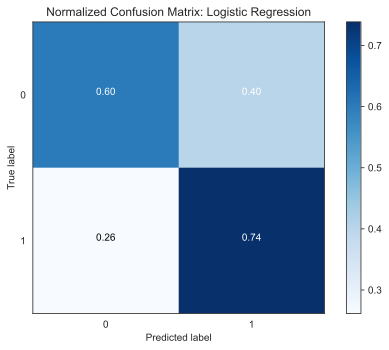

In [391]:
model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')


## Decision Trees

Accuracy Score is 0.75822
Precision Score is 0.69056
Recall Score is 0.93575
      0     1
0  3796  2741
1   420  6117
[[0.58069451 0.41930549]
 [0.06424966 0.93575034]]


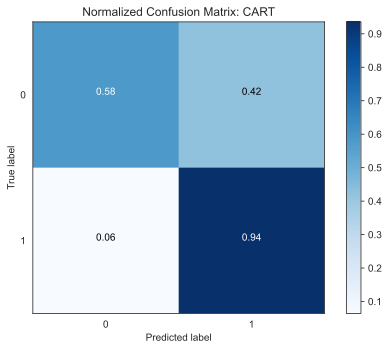

In [392]:
model = DecisionTreeClassifier(max_depth=12,
                               min_samples_split=8,
                               random_state=1024)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: CART') # Classification and Regression Trees

## Random Forest   



<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://d1rwhvwstyk9gu.cloudfront.net/2019/03/Random-Forest-Algorithm.jpg">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Random Forest</div>
</center>

Accuracy Score is 0.78109
      0     1
0  4368  2169
1   693  5844
[[0.66819642 0.33180358]
 [0.10601193 0.89398807]]


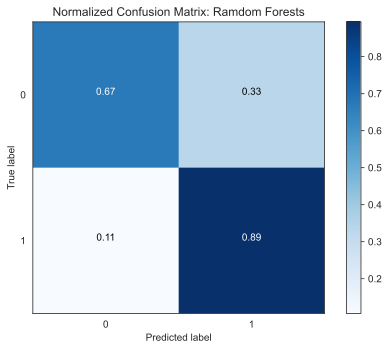

In [393]:
model = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Ramdom Forests')

## SVM


<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://i.loli.net/2019/11/13/fryWG5al7OPHDiA.gif">
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">Support Vector Machine</div>
</center>

Accuracy Score is 0.63844
Precision Score is 0.60587
Recall Score is 0.79226
      0     1
0  3168  3369
1  1358  5179
[[0.48462598 0.51537402]
 [0.20774055 0.79225945]]


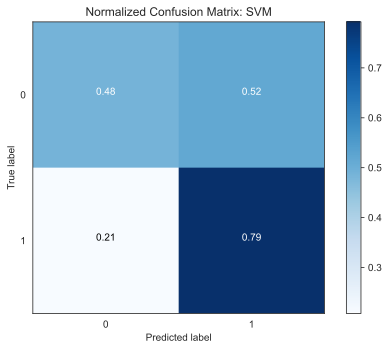

In [394]:
model = svm.SVC(C = 0.8,
                kernel='linear')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, normalize = True, 
                      title='Normalized Confusion Matrix: SVM')

## LightGBM

In [395]:
model = LGBMClassifier(num_leaves=31,
                       max_depth=8, 
                       learning_rate=0.02,
                       n_estimators=250,
                       subsample = 0.8,
                       colsample_bytree =0.8
                      )
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15252, number of negative: 15252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 30504, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy Score is 0.77474
   

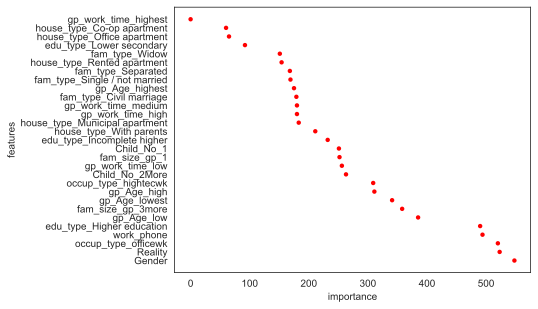

In [396]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')
    
plot_importance(model, X_train,20)   

## Xgboost

In [397]:
model = XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.82546
      0     1
0  4967  1570
1   712  5825


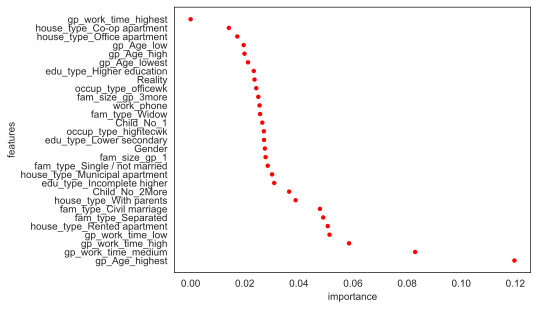

In [398]:
plot_importance(model, X_train, 20)   

## CatBoost

In [399]:
model = CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)

model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print('CatBoost Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

0:	learn: 0.5655671	total: 1.73s	remaining: 7m 10s
25:	learn: 0.3084179	total: 24.5s	remaining: 3m 31s
50:	learn: 0.2995869	total: 35.2s	remaining: 2m 17s
75:	learn: 0.2940865	total: 1m 4s	remaining: 2m 27s
100:	learn: 0.2927807	total: 1m 40s	remaining: 2m 27s
125:	learn: 0.2922441	total: 2m 14s	remaining: 2m 12s
150:	learn: 0.2919134	total: 2m 49s	remaining: 1m 50s
175:	learn: 0.2917212	total: 3m 23s	remaining: 1m 25s
200:	learn: 0.2915853	total: 3m 57s	remaining: 57.9s
225:	learn: 0.2914954	total: 4m 30s	remaining: 28.7s
249:	learn: 0.2914549	total: 4m 53s	remaining: 0us
CatBoost Accuracy Score is 0.85796
      0     1
0  5249  1288
1   569  5968
